# LSTM实现中文商品评论二分类

In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [6]:
import os
import csv
import time
import datetime
import random
import json
from collections import Counter
from math import sqrt
import gensim
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

import pkuseg
import jieba


from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,concatenate,Flatten,Dense,Dropout,Embedding,Reshape,LSTM
from tensorflow.keras import Sequential,optimizers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from bs4 import BeautifulSoup
import logging
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

import multiprocessing
import yaml
import jieba

In [7]:
np.__version__

'1.19.2'

# 参数配置

In [8]:
class Config(object):
    
    #数据集路径
    dataSource = "../02Data/goods_zh.txt"
    labelSource = "../02Data/完整数据_暴雨_交通_pre_tweets_TFIDF_Label.xlsx"
    labelSource = "../02Data/5006_final_微博数据集.xlsx"
    
    #分词后保留大于等于最低词频的词
    miniFreq=1
    
    
    #统一输入文本序列的定长，取了所有序列长度的均值。超出将被截断，不足则补0
    sequenceLength = 30
    batchSize= 8
    epochs= 30
    
    
    numClasses = 2
    #训练集的比例
    rate = 0.8  
    
    
    #生成嵌入词向量的维度
    embeddingSize = 30
    
    #卷积核数
    numFilters = 30
    
    #卷积核大小
    filterSizes = [2,3,4,5]
    dropoutKeepProb = 0.5
    
    #L2正则系数
    l2RegLambda = 0.1

    
# 实例化配置参数对象
config = Config()

In [9]:
config.labelSource

'../02Data/5006_final_微博数据集.xlsx'

# 文本预处理 流程（原来的一样，不做变化）

1. 文本去噪
2. 中文分词
3. 过滤停用词
4. 词性标注 【没有特殊需求，咱们就不用做了
5. 文本去重 【考虑发表的用户，**官方号**
6. 文本标记【手动整理模型输入数据
7. 特征词选择

In [10]:
# data = pd.read_csv("../02Data/完整数据_暴雨_交通.csv")
# df = data.sample(n=500, replace=False, random_state=1) # 指定随机种子，保证都是同一个数据组合
# df.reset_index(drop=True, inplace=True)
df = pd.read_excel(config.labelSource)
tweets = df.loc[:, ['微博正文']].astype("string") # 取100条数据就好了
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博正文    1093 non-null   string
dtypes: string(1)
memory usage: 8.7 KB


## 1 文本去噪

微博中的特殊符号，对于算法的训练来说不太有利

[Python正则表达式清洗微博文本特殊符号(网址, @, 表情符等)](https://blog.csdn.net/blmoistawinde/article/details/103648044)

[附：表达式全集（正则表达式手册）](https://blog.csdn.net/qq_33472765/article/details/80785441)

In [12]:
def clear_noise(text):
    """
    text 待去噪的原始文本
    """
    text = text.replace(u'\xa0', u' ')      # 去除 \xa0     不间断空白符 
    text = text.replace(u'\u3000', u' ')    # 去除 \u3000   全角的空白符
    
    # 匹配这些中文标点符号 。 ？ ！ ， 、 ； ： “ ” ‘ ' （ ） 《 》 〈 〉 【 】 『 』 「 」 ﹃ ﹄ 〔 〕 … — ～ ﹏ ￥
    reg1 = r"@\S*?"
    reg2 = r'[\s|\u3002|\uff1f|\uff01|\uff0c|\u3001|\uff1b|\uff1a|\u201c|\u201d|\u2018|\u2019|\uff08|\uff09|\u300a|\u300b|\u3008|\u3009|\u3010|\u3011|\u300e|\u300f|\u300c|\u300d|\ufe43|\ufe44|\u3014|\u3015|\u2026|\u2014|\uff5e|\ufe4f|\uffe5]'
    text = re.sub(r"(回复)?(//)?\s*", "", text)  # 去除正文中的@和回复/转发中的用户名
    text = re.sub(reg1+reg2, "", text)
    text = re.sub(r"\[\S+\]", "", text)     # 去除表情符号
    # text = re.sub(r"#\S+\s*#", "", text)    # 去除话题内容 “#content#”
    # text = re.sub(r"【\S+\s*】", "", text)  # 分类标签“【content】”

    URL_REGEX = re.compile(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
        re.IGNORECASE)
    text = re.sub(URL_REGEX, "", text)      # 去除网址
    
    EMAIL_REGEX = re.compile(r"[-a-z0-9_.]+@(?:[-a-z0-9]+\.)+[a-z]{2,6}", re.IGNORECASE)
    text = re.sub(EMAIL_REGEX, "", text)    # 去除邮件 
    
    text = text.replace("转发微博", "")      # 去除无意义的词语
    text = text.replace("网页链接", "")
    text = re.sub(r"\s+", " ", text)        # 合并正文中过多的空格

    text = re.sub(r"\d{2,4}年|\d{1,2}月|\d{1,2}日|\d{1,2}时|\d{1,2}分| \d{1,2}点", "", text) # 去除 日期 时间
    text = re.sub(r"\d", "", text)
    text = re.sub(r'[a-zA-Z]',"", text)
    
    return text.strip()

In [13]:
text = "#路况提示#截至16时11分，受暴雨天气影响，应交警要求，S81铜宜高速万宜段万载南站入口封闭，S81铜宜高速铜万段三兴站、罗城站、芳溪站、黄岗站、铜鼓东入口封闭。—ZGL@江西高速@江西交通@江西交通服务热线"
clear_noise(text)

'#路况提示#截至，受暴雨天气影响，应交警要求，铜宜高速万宜段万载南站入口封闭，铜宜高速铜万段三兴站、罗城站、芳溪站、黄岗站、铜鼓东入口封闭。—@江西高速@江西交通@江西交通服务热线'

In [86]:
tweets["去噪"] = tweets["微博正文"].apply(clear_noise).astype("string")
tweets.head()

,微博正文,去噪
0,路况信息：2021年5月29日17时05分，许广高速潭衡段射埠、回龙桥、青山桥收费站入口因暴...,路况信息：，许广高速潭衡段射埠、回龙桥、青山桥收费站入口因暴雨实行交通管制，至已解除交通管制...
1,路况信息：2021年5月29日10时25分，许广高速长湘段铜官、望城、乌山收费站入口因暴雨实...,路况信息：，许广高速长湘段铜官、望城、乌山收费站入口因暴雨实行交通管制，至已解除交通管制，恢...
2,路况信息：2021年5月29日10时24分，许广高速岳望段茶亭收费站入口因暴雨实行交通管制，...,路况信息：，许广高速岳望段茶亭收费站入口因暴雨实行交通管制，至已解除交通管制，恢复正常通行。
3,路况信息：2021年5月29日10时50分，许广高速潭衡段湘潭西、杨嘉桥、射埠、回龙桥收费站...,路况信息：，许广高速潭衡段湘潭西、杨嘉桥、射埠、回龙桥收费站入口因暴雨实行交通管制，至均已解...
4,路况信息：2021年5月29日10时50分，许广高速长湘段南谷收费站入口因暴雨实行交通管制，...,路况信息：，许广高速长湘段南谷收费站入口因暴雨实行交通管制，至已解除交通管制，恢复正常通行。


## 2 中文分词

[pkuseg: 一个多领域中文分词工具包](https://github.com/lancopku/pkuseg-python)

[jieba: 结巴中文分词](https://github.com/fxsjy/jieba)

从github下载的用户则需要自己下载对应的预训练模型，并设置model_name字段为预训练模型路径。预训练模型可以在[release](https://github.com/lancopku/pkuseg-python/releases)部分下载。以下是对预训练模型的说明：

- **news**: 在MSRA（新闻语料）上训练的模型。【可以测试
- **web**: 在微博（网络文本语料）上训练的模型。【可以测试
- **medicine**: 在医药领域上训练的模型。
- **tourism**: 在旅游领域上训练的模型。
- **mixed**: 混合数据集训练的通用模型。随pip包附带的是此模型。【可以测试

我们还通过领域自适应的方法，利用维基百科的未标注数据实现了几个细领域预训练模型的自动构建以及通用模型的优化，这些模型目前仅可以在release中下载：

- **art**: 在艺术与文化领域上训练的模型。
- **entertainment**: 在娱乐与体育领域上训练的模型。
- **science**: 在科学领域上训练的模型。
- **default_v2**: 使用领域自适应方法得到的优化后的通用模型，相较于默认模型规模更大，但泛化性能更好。

In [87]:
# jieba分词

def jieba_segment(str, use_paddle=True):
    """
    jieba分词:
    str         : 待分词的文本
    use_paddle  : 是否使用paddle模型
    """
    word_list = jieba.cut(str, use_paddle=use_paddle)   # 分词后返回一个列表  jieba.cut(）   返回的是一个迭代器
    res = list(word_list)
   
    return res

#! 测试
jieba_segment('我爱北京天安门')


['我', '爱', '北京', '天安门']

In [88]:
# pkuseg 分词 

def pkuseg_segment(str, m_name="web", u_dict="default"):
    """
    pkuseg分词:
    str     :待分词的文本
    m_name  : 选择使用的预训练模型
    u_dict  : 用户自定义的分词设置用户词典。
    """
    # m_name= "news"
    # m_name= "mixed"
    # p_tag= True # 是否包含词性
    seg = pkuseg.pkuseg(model_name=m_name, user_dict=u_dict)           # 以默认配置加载模型    
    res = seg.cut(str)  # 进行分词
   
    return res

#! 测试
pkuseg_segment('我爱北京天安门')

['我', '爱', '北京', '天安门']

In [89]:

tweets["jieba"] = tweets["去噪"].apply(jieba_segment)

In [90]:
#! 时间比较3min，轻易不尝试
# tweets["pkuseg"] = tweets["去噪"].apply(pkuseg_segment)

In [91]:
# tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博正文    1093 non-null   string
 1   去噪      1093 non-null   string
 2   jieba   1093 non-null   object
dtypes: object(1), string(2)
memory usage: 25.7+ KB


## 3 过滤停用词

- 支持新增停用词库
- 考虑词性标准时的去停用词
- 支持删除指定词性的词

In [92]:
def clear_stopword(word_ls, stopword_file, postag=False, stop_postag=[], user_file="../05stopwords/user_stopwords.txt"):
    """
    word_ls         :待去停用词的词汇列表【word 或者是 tuple(word, postag) 组成的list
    stopword_file   :选择使用的停用词库
    user_file       :用户自定义的停用词库
    postag          :是否有词性标注
    stop_postag     :指定删除的词性
    """
    with open(stopword_file, 'r', encoding='utf-8') as f1, open(user_file, 'r' , encoding='utf-8') as f2:    # 
        
        stopword_ls = [word.strip('\n') for word in f1.readlines()] # 默认词库
        user_ls = [word.strip('\n') for word in f2.readlines()]     # 自定义词库

        stopword_ls.extend(user_ls)
        
        res = []
        if postag: # 有词性标注
            for word_tag in word_ls:
                w, t = word_tag
                if w not in stopword_ls  and t not in stop_postag: # 仅保留2个字符及以上的词
                    res.append((w, t))
        else:
            for w in word_ls:
                if w not in stopword_ls : # 仅保留2个字符及以上的词
                    res.append(w)
    
    return res


#! 测试
word_ls = tweets["jieba"][9]
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = False
stop_postag = []
user_file = "../05stopwords/user_stopwords.txt"

res = clear_stopword(word_ls, stopword_file, postag, stop_postag, user_file)
print(res)

['三明', '路段', '多次', '发生', '山体', '滑坡', '泥石流', '交通', '中断', '连日', '暴雨', '线', '过境', '线', '上行', '梅列区', '徐碧', '街道', '翁墩', '互通', '三角区', '多次', '发生', '山体', '滑坡', '泥石流', '共计', '约', '立方米', '溜方', '造成', '交通', '中断', '目前', '暂', '无法', '预计', '恢复', '通行', '时间', '过往', '车辆', '市区', '绕行', '三明', '路段', '多次', '发生', '山体', '滑坡', '泥石流', '交通', '中断', '东南', '网', '三明', '站', '微博', '视频']


In [93]:
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = False
stop_postag = []

user_file = "../05stopwords/user_stopwords.txt"

tweets["jieba_stop"] = tweets["jieba"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])
# tweets["pkuseg_stop"] = tweets["pkuseg"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])


In [94]:
# tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   微博正文        1093 non-null   string
 1   去噪          1093 non-null   string
 2   jieba       1093 non-null   object
 3   jieba_stop  1093 non-null   object
dtypes: object(2), string(2)
memory usage: 34.3+ KB


## 4 分词+词性标注 


[pkuseg: 一个多领域中文分词工具包](https://github.com/lancopku/pkuseg-python)

[jieba: 结巴中文分词](https://github.com/fxsjy/jieba)



In [95]:
# jieba 词性标注（part-of-speech tagging）

def jieba_postag(str, use_paddle=True):
    """
    jieba分词:
    str         : 待分词的文本
    use_paddle  : 是否使用paddle模型
    """
    import jieba.posseg as pseg
    word_tag_ls = pseg.lcut(str, use_paddle=use_paddle)
    
    res = [] # 将词语与词性从pair对象转换为 元组，方便索引
    for w_t in word_tag_ls:
        w, t = w_t
        res.append((w, t))
    return res


#! 测试
res = jieba_postag('我爱北京天安门')
res

[('我', 'r'), ('爱', 'v'), ('北京', 'ns'), ('天安门', 'ns')]

In [96]:
# pkuseg 词性标注（part-of-speech tagging）
# pkuseg 分词 

def pkuseg_postag(str, m_name="web", u_dict="default", postag=True):
    """
    pkuseg分词:
    str     :待分词的文本
    m_name  : 选择使用的预训练模型
    u_dict  : 用户自定义的分词设置用户词典。
    postag   : 是否进行词性标准（是的话，需要在自定义的词典中，也要添加相应的词性 tab键隔开在一行
    """
    # m_name= "news"
    # m_name= "mixed"
    # postag= True # 是否包含词性
    seg = pkuseg.pkuseg(model_name=m_name, user_dict=u_dict, postag=postag)           # 以默认配置加载模型    
    res = seg.cut(str)  # 进行分词
   
    return seg.cut(str)  # 进行分词

#! 测试
res = pkuseg_postag('我爱北京天安门')
res

[('我', 'r'), ('爱', 'v'), ('北京', 'ns'), ('天安门', 'ns')]

In [97]:
#! 测试
word_str = tweets["去噪"][0]
print(word_str)

print("jieba:")
res = jieba_postag(word_str)
print(res)

print("pkuseg:")
res = pkuseg_postag(word_str)
print(res)


路况信息：，许广高速潭衡段射埠、回龙桥、青山桥收费站入口因暴雨实行交通管制，至已解除交通管制，恢复正常通行。
jieba:
[('路况', 'n'), ('信息', 'n'), ('：', 'x'), ('，', 'x'), ('许广', 'nr'), ('高速', 'd'), ('潭衡段', 'n'), ('射埠', 'n'), ('、', 'x'), ('回', 'v'), ('龙桥', 'ns'), ('、', 'x'), ('青山', 'ns'), ('桥', 'n'), ('收费站', 'n'), ('入口', 'ns'), ('因', 'p'), ('暴雨', 'n'), ('实行', 'v'), ('交通管制', 'n'), ('，', 'x'), ('至已', 'd'), ('解除', 'v'), ('交通管制', 'n'), ('，', 'x'), ('恢复正常', 'b'), ('通行', 'j'), ('。', 'x')]
pkuseg:
[('路况', 'n'), ('信息', 'n'), ('：', 'w'), ('，', 'w'), ('许广', 'nr'), ('高速', 'd'), ('潭衡', 'v'), ('段', 'n'), ('射埠', 'ns'), ('、', 'w'), ('回龙桥', 'n'), ('、', 'w'), ('青山桥', 'ns'), ('收费站', 'n'), ('入口', 'n'), ('因', 'c'), ('暴雨', 'n'), ('实行', 'v'), ('交通', 'n'), ('管制', 'vn'), ('，', 'w'), ('至', 'p'), ('已', 'd'), ('解除', 'v'), ('交通', 'n'), ('管制', 'vn'), ('，', 'w'), ('恢复', 'v'), ('正常', 'a'), ('通行', 'vn'), ('。', 'w')]


In [98]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   微博正文        1093 non-null   string
 1   去噪          1093 non-null   string
 2   jieba       1093 non-null   object
 3   jieba_stop  1093 non-null   object
dtypes: object(2), string(2)
memory usage: 34.3+ KB


In [99]:
tweets["jieba_postag"] = tweets["去噪"].apply(jieba_postag)
# tweets["pkuseg_postag"] = tweets["去噪"].apply(pkuseg_postag)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   微博正文          1093 non-null   string
 1   去噪            1093 non-null   string
 2   jieba         1093 non-null   object
 3   jieba_stop    1093 non-null   object
 4   jieba_postag  1093 non-null   object
dtypes: object(3), string(2)
memory usage: 42.8+ KB


In [100]:
stopword_file = "../05stopwords/hit_stopwords.txt"
postag = True

stop_postag = []

stop_postag= ['c', 'd', 'df', 'f', 'm', 'mq', 'ns', 'nt', 'nz', 'o','p','q','r','s',',t','nrfg'] # 指定词性删除

user_file = "../05stopwords/user_stopwords.txt"

tweets["jieba_postag_stop"] = tweets["jieba_postag"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])
# tweets["pkuseg_postag_stop"] = tweets["pkuseg_postag"].apply(clear_stopword, args=[stopword_file, postag, stop_postag, user_file])

In [101]:
# tweets.to_excel("../02Data/jieba_pkuseg.xlsx")
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   微博正文               1093 non-null   string
 1   去噪                 1093 non-null   string
 2   jieba              1093 non-null   object
 3   jieba_stop         1093 non-null   object
 4   jieba_postag       1093 non-null   object
 5   jieba_postag_stop  1093 non-null   object
dtypes: object(4), string(2)
memory usage: 51.4+ KB


In [102]:

tweets['jieba_stop_len'] = tweets['jieba_stop'].apply(len)
tweets['jieba_stop_postag_len'] = tweets['jieba_postag_stop'].apply(len)

tweets.head()

,微博正文,去噪,jieba,jieba_stop,jieba_postag,jieba_postag_stop,jieba_stop_len,jieba_stop_postag_len
0,路况信息：2021年5月29日17时05分，许广高速潭衡段射埠、回龙桥、青山桥收费站入口因暴...,路况信息：，许广高速潭衡段射埠、回龙桥、青山桥收费站入口因暴雨实行交通管制，至已解除交通管制...,"[路况, 信息, ：, ，, 许广, 高速, 潭衡, 段, 射埠, 、, 回, 龙桥, 、,...","[路况, 信息, 许广, 高速, 潭衡, 段, 射埠, 回, 龙桥, 青山, 桥, 收费站,...","[(路况, n), (信息, n), (：, x), (，, x), (许广, nr), (...","[(路况, n), (信息, n), (许广, nr), (潭衡段, n), (射埠, n)...",21,15
1,路况信息：2021年5月29日10时25分，许广高速长湘段铜官、望城、乌山收费站入口因暴雨实...,路况信息：，许广高速长湘段铜官、望城、乌山收费站入口因暴雨实行交通管制，至已解除交通管制，恢...,"[路况, 信息, ：, ，, 许广, 高速, 长湘段, 铜官, 、, 望城, 、, 乌山, ...","[路况, 信息, 许广, 高速, 长湘段, 铜官, 望城, 乌山, 收费站, 入口, 暴雨,...","[(路况, n), (信息, n), (：, x), (，, x), (许广, nr), (...","[(路况, n), (信息, n), (许广, nr), (长, a), (湘, j), (...",18,15
2,路况信息：2021年5月29日10时24分，许广高速岳望段茶亭收费站入口因暴雨实行交通管制，...,路况信息：，许广高速岳望段茶亭收费站入口因暴雨实行交通管制，至已解除交通管制，恢复正常通行。,"[路况, 信息, ：, ，, 许广, 高速, 岳望, 段, 茶亭, 收费站, 入口, 因, ...","[路况, 信息, 许广, 高速, 岳望, 段, 茶亭, 收费站, 入口, 暴雨, 实行, 交...","[(路况, n), (信息, n), (：, x), (，, x), (许广, nr), (...","[(路况, n), (信息, n), (许广, nr), (岳望, nr), (茶亭, n)...",17,13
3,路况信息：2021年5月29日10时50分，许广高速潭衡段湘潭西、杨嘉桥、射埠、回龙桥收费站...,路况信息：，许广高速潭衡段湘潭西、杨嘉桥、射埠、回龙桥收费站入口因暴雨实行交通管制，至均已解...,"[路况, 信息, ：, ，, 许广, 高速, 潭衡, 段, 湘潭, 西, 、, 杨嘉桥, 、...","[路况, 信息, 许广, 高速, 潭衡, 段, 湘潭, 西, 杨嘉桥, 射埠, 回, 龙桥,...","[(路况, n), (信息, n), (：, x), (，, x), (许广, nr), (...","[(路况, n), (信息, n), (许广, nr), (潭衡段, n), (杨嘉桥, n...",23,15
4,路况信息：2021年5月29日10时50分，许广高速长湘段南谷收费站入口因暴雨实行交通管制，...,路况信息：，许广高速长湘段南谷收费站入口因暴雨实行交通管制，至已解除交通管制，恢复正常通行。,"[路况, 信息, ：, ，, 许广, 高速, 长湘段, 南谷, 收费站, 入口, 因, 暴雨...","[路况, 信息, 许广, 高速, 长湘段, 南谷, 收费站, 入口, 暴雨, 实行, 交通管...","[(路况, n), (信息, n), (：, x), (，, x), (许广, nr), (...","[(路况, n), (信息, n), (许广, nr), (段南谷, nr), (收费站, ...",16,12


In [103]:
# 长度均值

tweets[['jieba_stop_postag_len', 'jieba_stop_len']].mean()


jieba_stop_postag_len    23.152790
jieba_stop_len           29.642269
dtype: float64

## 5 保存数据

In [104]:
dataSource = config.dataSource
# 词汇信息
word_ls_column = tweets["jieba_postag_stop"] # 从excel再读取回来，就不是[(),()] 和数据了
word  =[]
tag = []
for word_tag_ls in word_ls_column: # 遍历一整列的每一行
    word_ls = np.array(word_tag_ls)[:, 0].tolist() # 词
    tag_ls = np.array(word_tag_ls)[:, 1].tolist() # 词性
    word.append(word_ls)
    tag.append(tag_ls)

len(word)

# # 换一列
word = tweets["jieba_stop"].tolist()

with open(dataSource, 'w',encoding='utf-8') as outfile:
    for w in word:
        temp = ','.join(w)
        outfile.write(temp)
        outfile.write('\n')

In [146]:
# 向量化
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def wordVectorizer(word_ls_column, v_type, postag=True):
    ls_str=[]
    if postag:
        for word_tag_ls in word_ls_column:
            if word_tag_ls == []:
                word_tag_ls = [('','')]
            word_ls = np.array(word_tag_ls)[:, 0].tolist()
            tag_ls = np.array(word_tag_ls)[:, 1].tolist()
            
            strs = ' '.join(word_ls)
            ls_str.append(strs)
    else:
        for word_ls in word_ls_column:
            strs = ' '.join(word_ls) 
            ls_str.append(strs)
    
    if v_type.upper() == "TFIDF":
    # TF-IDF(term frequency—inverse document frequency)
        transfer = TfidfVectorizer() #实例化一个转换器类
    else:
        transfer = CountVectorizer()
    data_new = transfer.fit_transform(ls_str) #调用fit_transform()
    #构建成一个二维表：
    df=pd.DataFrame(data_new.toarray(), columns=transfer.get_feature_names_out())
    
    withWeight = transfer.vocabulary_
    return df, withWeight

In [151]:

# 向量化

word_ls_column = tweets['jieba_postag_stop']
postag = True

# word_ls_column = tweets['jieba_stop']
# postag = False

v_type = 'TFIDF'
word_v, withWeight = wordVectorizer(word_ls_column, v_type, postag)
res_file = "../02Data/5006_final_微博数据集-TFIDF.csv"
word_v.to_csv(res_file, index=None)

In [152]:
word_v.shape

(1093, 3521)

# 预训练词向量

In [127]:
#中文语料
#设置输出日志
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# file = open("../data/goods_zh.txt", encoding='utf-8') 
# sentences=[]
# for line in file:
#     temp=line.replace('\n','').split(',,')
#     sentences.append(jieba.lcut(temp[0]))
# file.close()

sentences = word

In [128]:
print(sentences[0])
print(len(sentences))

['路况', '信息', '许广', '高速', '潭衡', '段', '射埠', '回', '龙桥', '青山', '桥', '收费站', '入口', '暴雨', '实行', '交通管制', '已', '解除', '交通管制', '恢复正常', '通行']
1093


In [129]:
word2VecModel_file = '../02Data/word2VecModel'
model = word2vec.Word2Vec(sentences,
                    #  size=config.embeddingSize,
                     vector_size=config.embeddingSize,
                     min_count=config.miniFreq,
                     window=10,
                     workers=multiprocessing.cpu_count(),
                     sg=1,
                    #  iter=20,
                     epochs=20
                     )
model.save(word2VecModel_file)


In [130]:
# help(word2vec.Word2Vec)

In [131]:
model = gensim.models.Word2Vec.load(word2VecModel_file)

keys = model.wv.index_to_key
len(keys)
# keys
# model.wv.vocab.keys()
# key_to_index()

5657

In [132]:
# help(model.wv.key_to_index)

In [133]:
model.wv['暴雨']

array([-0.419994  , -0.5792639 ,  0.45151553,  1.0119973 , -0.11630163,
       -0.20092054,  0.77790517,  1.0163444 , -0.7766697 , -0.307387  ,
        0.17888422,  0.37273785, -0.46540403,  0.4890284 ,  0.3979262 ,
       -0.11717456, -0.10698257, -0.734322  ,  0.01641443,  0.73694265,
        0.30064058,  0.42214268,  0.39464733,  0.63104206, -0.18064132,
       -0.5421013 ,  0.8978401 , -0.28479648, -0.28979754, -0.58586144],
      dtype=float32)

In [134]:
# help(model)

# 数据预处理 - 输入LSTM

In [135]:
# 数据预处理的类，生成训练集和测试集
class Dataset(object):
    def __init__(self, config):
        self.dataSource = config.dataSource  
        self.labelSource = config.labelSource

        # 每条输入的序列处理为定长
        self.sequenceLength = config.sequenceLength  
        
        self.embeddingSize = config.embeddingSize
        self.batchSize = config.batchSize
        self.rate = config.rate
        self.miniFreq=config.miniFreq
        
        
        self.trainReviews = []
        self.trainLabels = []
        
        self.evalReviews = []
        self.evalLabels = []
        
        self.wordEmbedding =None
        self.n_symbols=0
        
        self.wordToIndex = {}
        self.indexToWord = {}
        
        
        
    def readData(self, dataFilePath, labelFilePath):
        file = open(dataFilePath, encoding='utf-8') 
        texts=[]
        for line in file:
            temp=line.replace('\n','').split(',')
            texts.append(temp)
        file.close()
        
        df = pd.read_excel(labelFilePath, index_col=0)
        labels = df.iloc[:, -1].tolist()

        print('data:',len(texts),len(labels))
        
        return texts, labels

    
    def getWordEmbedding(self, words):
        """
        按照我们的数据集中的单词取出预训练好的word2vec中的词向量
        """
        
        #中文
        word2VecModel_file = '../02Data/word2VecModel'
        model = gensim.models.Word2Vec.load(word2VecModel_file)
        
        vocab = []
        wordEmbedding = []
        
        # 添加 "pad" 和 "UNK", 
        vocab.append("pad")
        wordEmbedding.append(np.zeros(self.embeddingSize))
        
        vocab.append("UNK")
        wordEmbedding.append(np.random.randn(self.embeddingSize))
        
        for word in words:
            try:        
                #中文
                vector =model.wv[word]
                
                vocab.append(word)
                wordEmbedding.append(vector)
            except:
                
                print(word + " : 不存在于词向量中")
                
        return vocab, np.array(wordEmbedding)
    
    
    
    def genVocabulary(self, reviews):
        """
        生成词向量和词汇-索引映射字典，可以用全数据集
        """
        
        allWords = [word for review in reviews for word in review]
        
        # # 去掉停用词
        # subWords = [word for word in allWords if word not in self.stopWordDict]
        
        wordCount = Counter(allWords)  # 统计词频，排序
        sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
        
        # 去除低频词
        words = [item[0] for item in sortWordCount if item[1] >= self.miniFreq ]
        
        
        #获取词列表和顺序对应的预训练权重矩阵
        vocab, wordEmbedding = self.getWordEmbedding(words)
        
        self.wordEmbedding = wordEmbedding
        
        self.wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
        self.indexToWord = dict(zip(list(range(len(vocab))), vocab))
        self.n_symbols = len(self.wordToIndex) + 1
        
        # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
        with open("../02Data/wordJson/wordToIndex.json", "w", encoding="utf-8") as f:
            json.dump(self.wordToIndex, f)
        
        with open("../02Data/wordJson/indexToWord.json", "w", encoding="utf-8") as f:
            json.dump(self.indexToWord, f)
            
            
            
            
    
    def reviewProcess(self, review, sequenceLength, wordToIndex):
        """
        将数据集中的每条评论里面的词，根据词表，映射为index表示
        每条评论 用index组成的定长数组来表示
        review ： 一条文本
        """
        
        reviewVec = np.zeros((sequenceLength))
        sequenceLen = sequenceLength
        
        # 判断当前的序列是否小于定义的固定序列长度
        if len(review) < sequenceLength:
            sequenceLen = len(review)
            
        for i in range(sequenceLen):
            if review[i] in wordToIndex:
                reviewVec[i] = wordToIndex[review[i]]
            else:
                reviewVec[i] = wordToIndex["UNK"]

        return reviewVec

    
    
    
    def genTrainEvalData(self, x, y, rate):
        """
        生成训练集和验证集
        x 所有样本
        """
        
        reviews = [] # 样本
        labels = [] # 标签
        
        # 遍历所有的文本，将文本中的词转换成index表示
        for i in range(len(x)):
            
            reviewVec = self.reviewProcess(x[i], self.sequenceLength, self.wordToIndex)
            reviews.append(reviewVec)
            
            labels.append([y[i]])
            
        trainIndex = int(len(x) * rate)
        
       
        #trainReviews = sequence.pad_sequences(reviews[:trainIndex], maxlen=self.sequenceLength)
        trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
        trainLabels = np.array(labels[:trainIndex], dtype="float32")
        trainLabels = to_categorical(trainLabels,num_classes=2) 
        
        #evalReviews = sequence.pad_sequences(reviews[trainIndex:], maxlen=self.sequenceLength)
        evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
        evalLabels = np.array(labels[trainIndex:], dtype="float32")
        evalLabels = to_categorical(evalLabels,num_classes=2)  #　转换为分类变量

        return trainReviews, trainLabels, evalReviews, evalLabels
        
        
        
 
            
    def dataGen(self):
        """
        初始化训练集和验证集
        """
        
        
        #读取数据集
        reviews, labels = self.readData(self.dataSource, self.labelSource)
        
        
        #生成 词汇-索引 映射表和预训练权重矩阵，并保存
        self.genVocabulary(reviews)
        
        
        #初始化训练集和测试集
        trainReviews, trainLabels, evalReviews, evalLabels = self.genTrainEvalData(reviews, labels, self.rate)
        self.trainReviews = trainReviews
        self.trainLabels = trainLabels
        
        self.evalReviews = evalReviews
        self.evalLabels = evalLabels
        
        
data = Dataset(config)
data.dataGen()

data: 1093 1093


In [136]:
print("train data shape: {}".format(data.trainReviews.shape))
print("train label shape: {}".format(data.trainLabels.shape))
print("eval data shape: {}".format(data.evalReviews.shape))
print("eval label shape: {}".format(data.evalLabels.shape))

train data shape: (874, 30)
train label shape: (874, 2)
eval data shape: (219, 30)
eval label shape: (219, 2)


In [137]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# 定义网络结构

In [138]:

def lstm(n_symbols,embedding_weights,config):
    
    model =Sequential([
        Embedding(input_dim=n_symbols, output_dim=config.embeddingSize,
                        weights=[embedding_weights],
                        input_length=config.sequenceLength),
        
        #LSTM层
        #LSTM(50,activation='tanh', dropout=0.5, recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(config.model.l2RegLambda)),
        LSTM(50,activation='tanh', dropout=0.5, recurrent_dropout=0.5),

        Dropout(config.dropoutKeepProb),
        Dense(2, activation='softmax')
                    ])
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model
    
    
wordEmbedding = data.wordEmbedding
# n_symbols=data.n_symbols # 前面搞不懂为啥加了1 但是对不上
n_symbols=data.n_symbols -1
print(np.shape(wordEmbedding))
print(n_symbols)
model = lstm(n_symbols, wordEmbedding, config)
model.summary()

(5659, 30)
5659
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 30)            169770    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 186,072
Trainable params: 186,072
Non-trainable params: 0
_________________________________________________________________


In [139]:
np.shape(wordEmbedding)


(5659, 30)

# 训练模型

In [140]:
x_train = data.trainReviews
y_train = data.trainLabels
x_eval = data.evalReviews
y_eval = data.evalLabels

wordEmbedding = data.wordEmbedding
n_symbols=data.n_symbols


reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model_checkpoint = ModelCheckpoint('./lstm_model/best_model/model_{epoch:02d}-{val_accuracy:.2f}.hdf5', save_best_only=True, save_weights_only=True)
history = model.fit(x_train, y_train, batch_size=config.batchSize, epochs=config.epochs, validation_split=0.2,shuffle=True, callbacks=[reduce_lr,early_stopping,model_checkpoint])
#验证

scores = model.evaluate(x_eval, y_eval)

#保存模型
yaml_string = model.to_yaml()
with open('./lstm_model/lstm.yml', 'w') as outfile:
    outfile.write( yaml.dump(yaml_string, default_flow_style=True) )
model.save_weights('./lstm_model/lstm.h5')

print('test_loss: %f, accuracy: %f' % (scores[0], scores[1]))

Train on 699 samples, validate on 175 samples
Epoch 1/30
699/699 [==============================] - 2s 2ms/sample - loss: 0.6080 - accuracy: 0.6423 - val_loss: 0.4069 - val_accuracy: 0.8571
Epoch 2/30
699/699 [==============================] - 1s 839us/sample - loss: 0.4341 - accuracy: 0.8169 - val_loss: 0.2772 - val_accuracy: 0.8971
Epoch 3/30
699/699 [==============================] - 1s 853us/sample - loss: 0.3927 - accuracy: 0.8441 - val_loss: 0.2629 - val_accuracy: 0.9143
Epoch 4/30
699/699 [==============================] - 1s 827us/sample - loss: 0.4071 - accuracy: 0.8441 - val_loss: 0.2846 - val_accuracy: 0.9029
Epoch 5/30
699/699 [==============================] - 1s 814us/sample - loss: 0.3801 - accuracy: 0.8412 - val_loss: 0.2684 - val_accuracy: 0.9143
Epoch 6/30
699/699 [==============================] - 1s 829us/sample - loss: 0.3161 - accuracy: 0.8798 - val_loss: 0.2554 - val_accuracy: 0.9029
Epoch 7/30
699/699 [==============================] - 1s 846us/sample - loss: 0.

In [119]:
# help( model.fit)

In [141]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

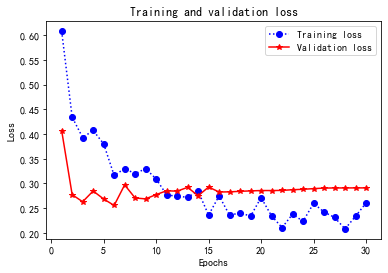

min loss: 0.6079561432799556
min val loss: 0.4069052175113133


In [142]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, ':bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, '-r*', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(f"min train loss: {np.max(loss)}")
print(f"min val loss: {np.max(val_loss)}")

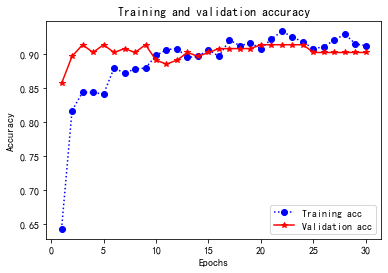

max acc: 0.9341917037963867
max val acc: 0.9142857193946838


In [143]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, ':bo', label='Training acc')
plt.plot(epochs, val_acc, '-r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(f"max train acc: {np.max(acc)}")
print(f"max val acc: {np.max(val_acc)}")